In [250]:
%matplotlib inline
import math as m
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from SAMPEX_functions import read_counts as read
from SAMPEX_functions import mb_finder, read_days, mb_magnitude, iso_calculator, OrbAtt_augment
import pandas as pd
import os
import pathlib
import string
import datetime

In [251]:
# defining file
year = '1993'
start_day = '335'
num_days = 6
month = (datetime.datetime(int(year), 1, 1) + datetime.timedelta(int(start_day)-1)).month
day = (datetime.datetime(int(year), 1, 1) + datetime.timedelta(int(start_day)-1)).day

In [252]:
# set end_day
if int(start_day[1]) < 9 or int(start_day[2]) < 4:
    if start_day[0] != '0':
        end_day = str(int(start_day) + (num_days-1))
    elif start_day[0] == '0' and start_day[1] != '0':
        end_day = '0' + str(int(start_day) + (num_days-1))
    elif start_day[0] == '0' and start_Day[1] == '0':
        end_day = '00' + str(int(start_day) + (num_days-1))
elif int(start_day[1]) >= 9 or int(start_day[2]) >= 4:
    end_day = str(int(start_day) + (num_days-1))

In [253]:
# define pic_directory
pic_directory = 'C:\\Users\\jacob\\Documents\\CU_Boulder\\Research\\LASP\\lasp-research\\sampexlib\\GMS Catalog\\' + year + '\\' + year + start_day + '-' + year + end_day + '\\'

# create new folder if it does not exist
if os.path.isdir(pic_directory) == False:
    os.mkdir(pic_directory)

In [254]:
# reading in electron counts files:
t, r1, r2, r3, r4 = read_days(year, start_day, num_days, month)

In [255]:
# find microburst times and N_100, SSD1, SSD4 counts using algorithm
t_microburst, N_100_microburst, r1_microburst, r4_microburst, mb_index, MB_mask, N_100, A_500 = mb_finder(t, r1, r2, r3, r4)

In [256]:
BG_mask = ~MB_mask
# calculation of the isotropy indices of electron counts
iso_indices_MB = iso_calculator(r1[MB_mask], r4[MB_mask])
iso_indices_BG = iso_calculator(r1[BG_mask], r4[BG_mask])

In [257]:
# reading in orbit/attitude data file
directory = 'D:\SAMPEX_Data\\'
OA_file = 'OrbAtt_' + year + start_day + '-' + year + end_day + '.txt'
OrbAtt_data = pd.read_csv(directory + OA_file, names = ['sec_of_day', 'GEO_Radius', 'GEO_Long', 'GEO_Lat', 'Altitude', 'L_Shell', 'MLT', 
                                         'SAA_Flag', 'Pitch', 'zenith', 'azimuth', 'Att_Flag'], sep = '\s+', header = 70)

t_OrbAtt, LS_OrbAtt, MLT_OrbAtt, P_OrbAtt, Lat_OrbAtt, Long_OrbAtt, R_OrbAtt = OrbAtt_augment(t, OrbAtt_data, num_days)

t_OrbAtt_mb = t_OrbAtt[mb_index]; LS_OrbAtt_mb = LS_OrbAtt[mb_index]; MLT_OrbAtt_mb = MLT_OrbAtt[mb_index];
P_OrbAtt_mb = P_OrbAtt[mb_index]; Lat_OrbAtt_mb = Lat_OrbAtt[mb_index]; Long_OrbAtt_mb = Long_OrbAtt[mb_index];
R_OrbAtt_mb = R_OrbAtt[mb_index]

In [258]:
# defining month
month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# reading in magnetosphere indices
directory = 'D:\SAMPEX_Data\\'
file = 'mag_indices_' + month_list[month-1] + year + start_day + '.csv'
Mag_Indices = pd.read_csv(directory + file, header = 0, comment = '#')

AE_indices = Mag_Indices['5-M_AE_nT'].values
Dst_indices = Mag_Indices['SYM/H_INDEX_nT'].values

t_str = Mag_Indices['EPOCH_TIME_yyyy-mm-ddThh:mm:ss.sssZ'].values
t_mag = np.array([])

for i in np.arange(len(t_str)):
    if t_str[i][5:7] != t_str[0][5:7]:
        days_in_month = input('Days in the first month: ')
        break
    
for i in np.arange(len(t_str)):
    if t_str[i][5:7] == t_str[0][5:7]:
        t_i = (int(t_str[i][8:10])-int(t_str[0][8:10])) * 86400 + int(t_str[i][11:13]) * 3600 + int(t_str[i][14:16]) * 60
    elif t_str[i][5:7] != t_str[0][5:7]:
        t_i = (int(days_in_month) + int(t_str[i][8:10])-int(t_str[0][8:10])) * 86400 + int(t_str[i][11:13]) * 3600 + \
        int(t_str[i][14:16]) * 60
    t_mag = np.append(t_mag, t_i)

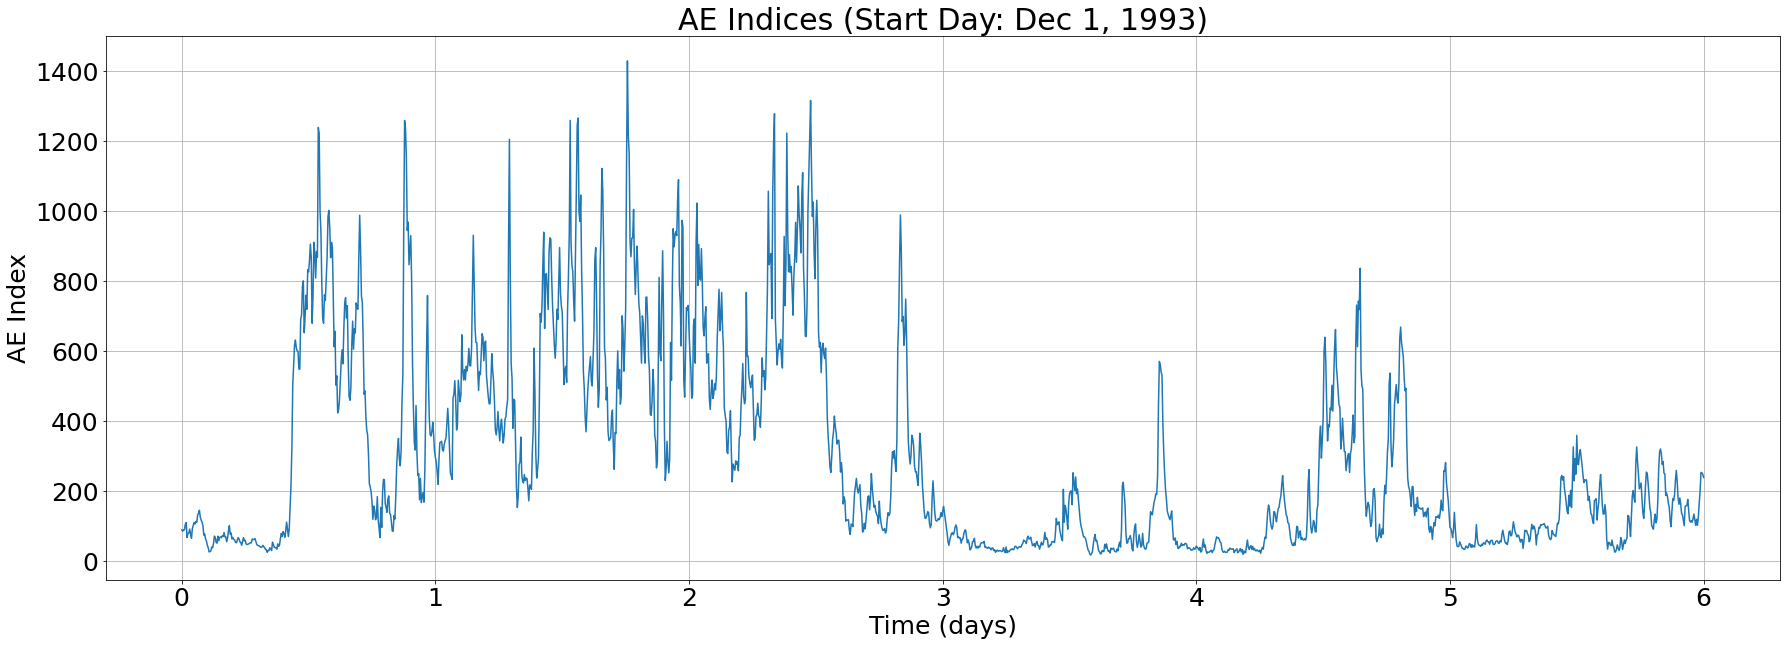

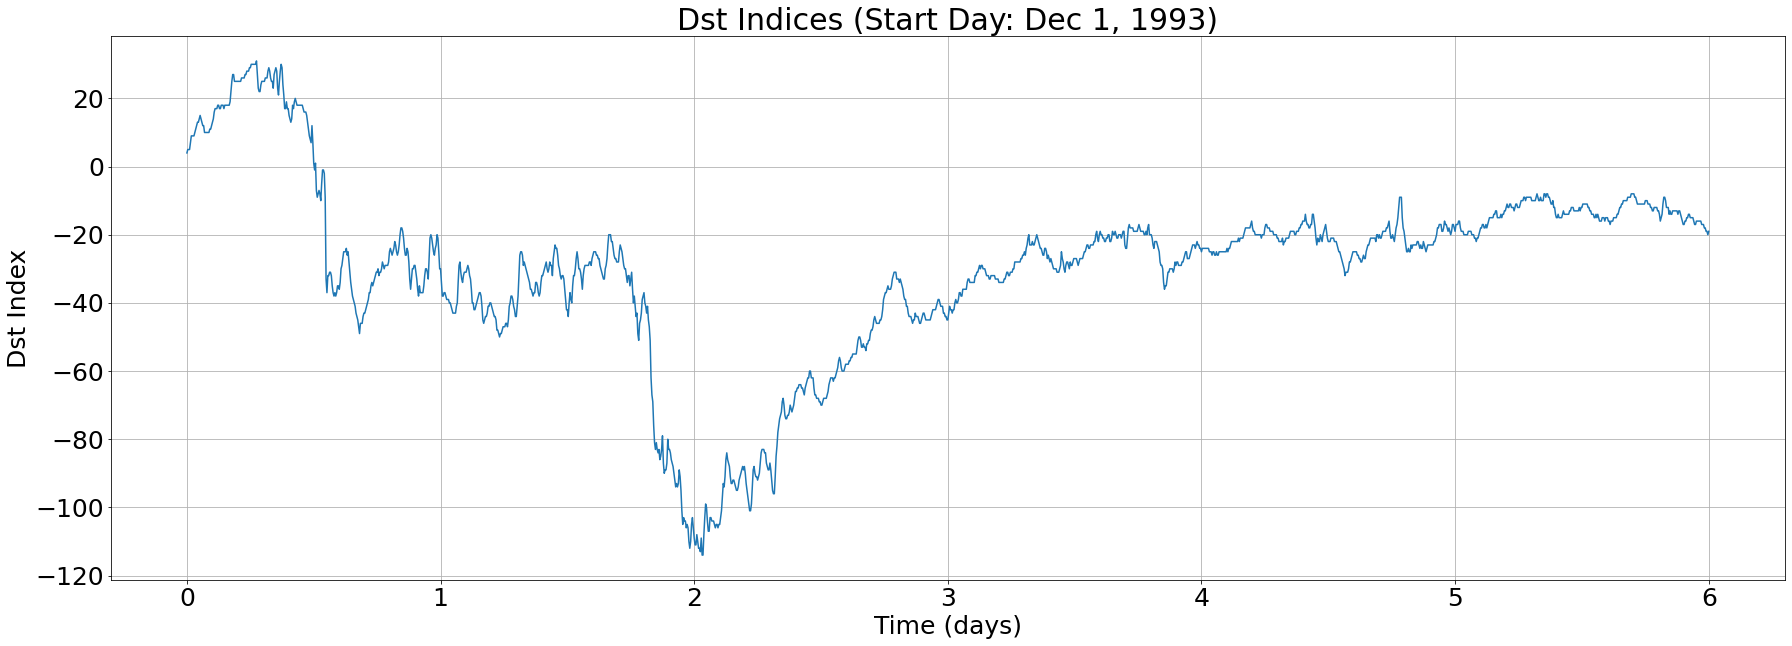

In [259]:
x_ticks = np.linspace(0, num_days*86400, num_days+1)
x_names = np.arange(0, num_days+1)

# plotting mag AE indices
plt.figure(figsize = (30,10))
plt.title(f'AE Indices (Start Day: {month_list[month-1]} {day}, {year})', fontsize = 30)
plt.plot(t_mag, AE_indices)
plt.xlabel('Time (days)', fontsize = 25)
plt.ylabel('AE Index', fontsize = 25)
plt.xticks(x_ticks, x_names, fontsize = 25)
plt.yticks(fontsize = 25)
plt.grid(True)
plt.show()

# plotting mag Dst indices
plt.figure(figsize = (30,10))
plt.title(f'Dst Indices (Start Day: {month_list[month-1]} {day}, {year})', fontsize = 30)
plt.plot(t_mag, Dst_indices)
plt.xlabel('Time (days)', fontsize = 25)
plt.ylabel('Dst Index', fontsize = 25)
plt.xticks(x_ticks, x_names, fontsize = 25)
plt.yticks(fontsize = 25)
plt.grid(True)
plt.show()

In [260]:
# find _ hr average the AE/Dst indices
bin_size = 3              # in hours
interval = 24*num_days    # in hours

t_per3hrs = np.arange(0, interval*12, bin_size*12)
index_per3hrs = np.arange(bin_size*12-1, interval*12, bin_size*12)

AE_series = pd.Series(AE_indices)
Dst_series = pd.Series(Dst_indices)
AE_per3hrs = np.array(AE_series.rolling(bin_size*12, center=False).max())[index_per3hrs]
Dst_per3hrs = np.array(Dst_series.rolling(bin_size*12, center=False).min())[index_per3hrs]

# categorize Dst indices
t_max = t_per3hrs[Dst_per3hrs == np.max(Dst_per3hrs)]; t_Dmax = [t_max] if isinstance(t_max, int) else t_max
t_min = t_per3hrs[Dst_per3hrs == np.min(Dst_per3hrs)]; t_Dmin = [t_min] if isinstance(t_min, int) else t_min

t_prestorm = t_per3hrs[t_per3hrs <= t_Dmax[0]]
Dst_prestorm = Dst_per3hrs[t_per3hrs <= t_Dmax[0]]
t_mainphase = t_per3hrs[(t_per3hrs >= t_Dmax[0]) & (t_per3hrs <= t_Dmin[0])]
Dst_mainphase = Dst_per3hrs[(t_per3hrs >= t_Dmax[0]) & (t_per3hrs <= t_Dmin[0])]
t_recovery = t_per3hrs[t_per3hrs >= t_Dmin[0]]
Dst_recovery = Dst_per3hrs[t_per3hrs >= t_Dmin[0]]

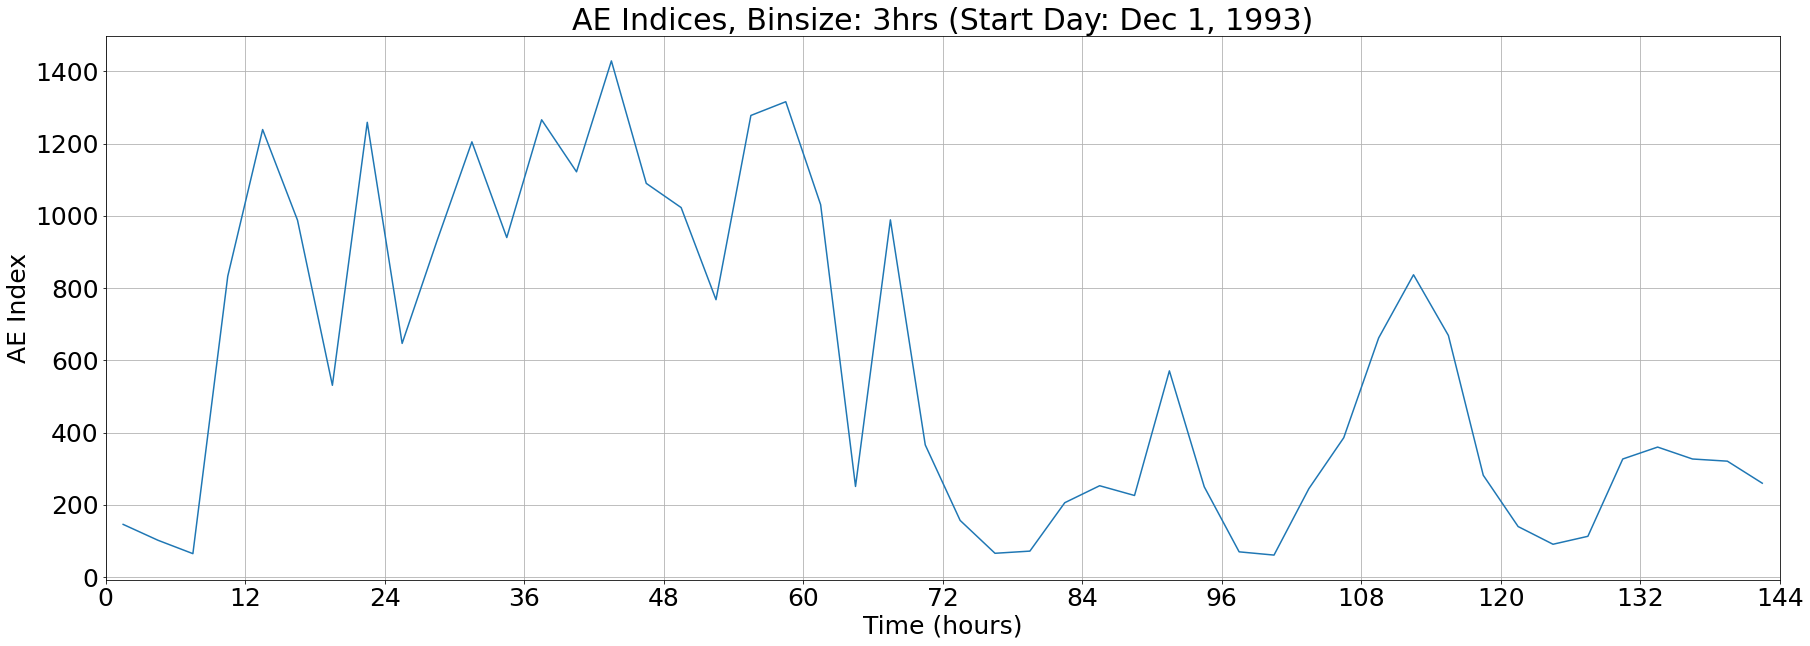

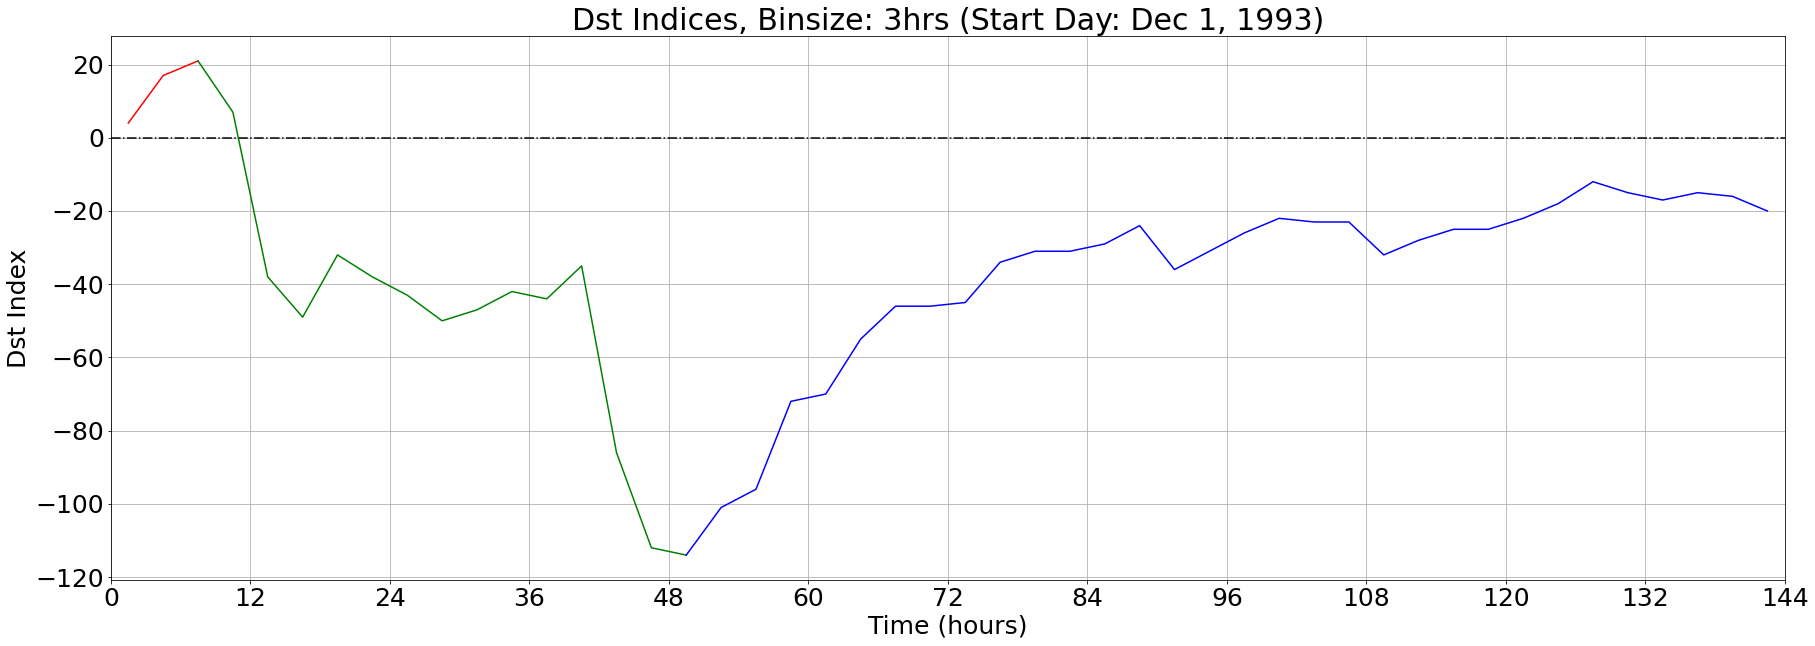

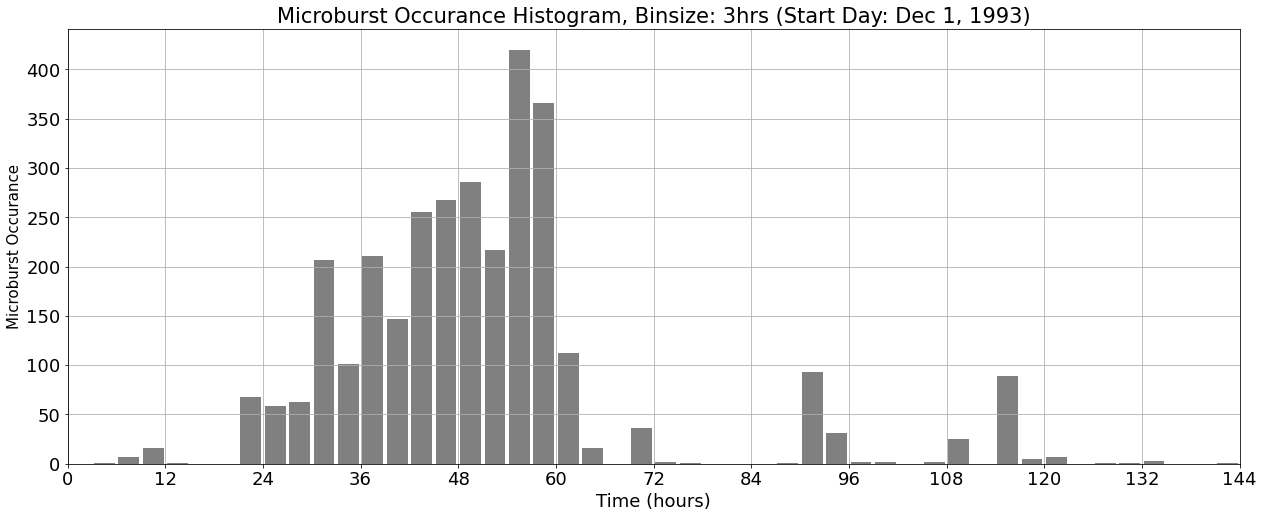

In [261]:
# plotting mag AE indices
plt.figure(figsize = (30,10))
plt.title(f'AE Indices, Binsize: {bin_size}hrs (Start Day: {month_list[month-1]} {day}, {year})', fontsize = 30)
plt.plot((t_per3hrs/12)+bin_size/2, AE_per3hrs)
plt.xlabel('Time (hours)', fontsize = 25)
plt.ylabel('AE Index', fontsize = 25)
plt.xlim(0,interval)
plt.xticks(np.arange(0, interval+12, 12), fontsize = 25)
plt.yticks(fontsize = 25)
plt.grid(True)
plt.show()

# plotting mag Dst indices
plt.figure(figsize = (30,10))
plt.title(f'Dst Indices, Binsize: {bin_size}hrs (Start Day: {month_list[month-1]} {day}, {year})', fontsize = 30)

plt.plot([0,t_recovery[-1]], [0,0], color='k', linestyle='-.')
plt.plot(t_prestorm/12+bin_size/2, Dst_prestorm, color='red')
plt.plot(t_mainphase/12+bin_size/2, Dst_mainphase, color='green')
plt.plot(t_recovery/12+bin_size/2, Dst_recovery, color='blue')

plt.xlabel('Time (hours)', fontsize = 25)
plt.ylabel('Dst Index', fontsize = 25)
plt.xlim(0,interval)
plt.xticks(np.arange(0, interval+12, 12), fontsize = 25)
plt.yticks(fontsize = 25)
plt.grid(True)
plt.show()

# microburst occurance histogram
plt.figure(figsize = (21,8))
H = np.array(plt.hist(t_microburst/3600, bins=[bin_size*i for i in range(int(interval/bin_size)+1)], color = 'grey', rwidth=0.85))
plt.title(f'Microburst Occurance Histogram, Binsize: {bin_size}hrs (Start Day: {month_list[month-1]} {day}, {year})', fontsize = 21)
plt.xlabel('Time (hours)', fontsize = 18)
plt.ylabel('Microburst Occurance', fontsize = 15)
plt.xlim(0,interval)
plt.xticks(np.arange(0, interval+12, 12), fontsize = 18)
plt.yticks(fontsize = 18)
plt.grid(True)

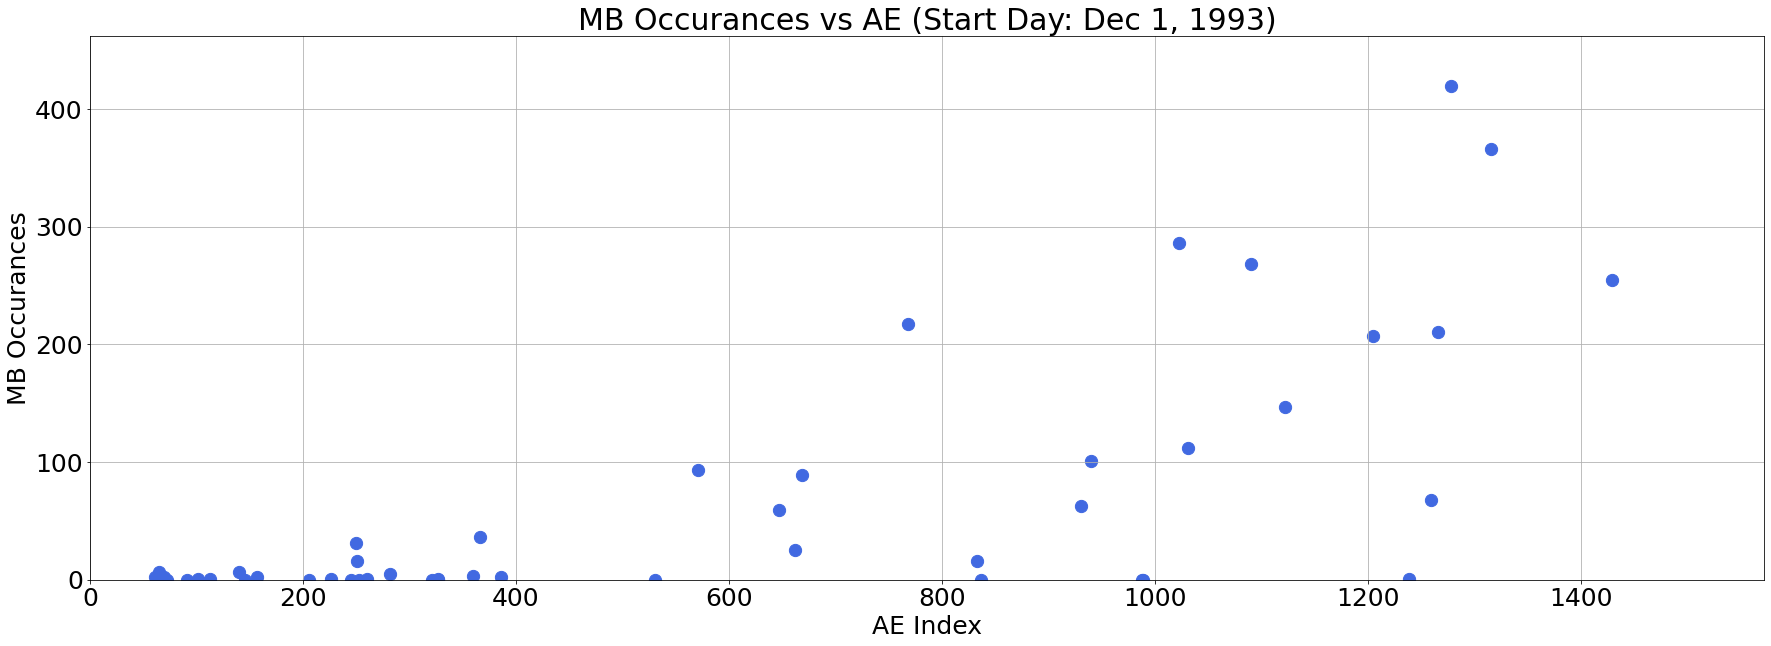

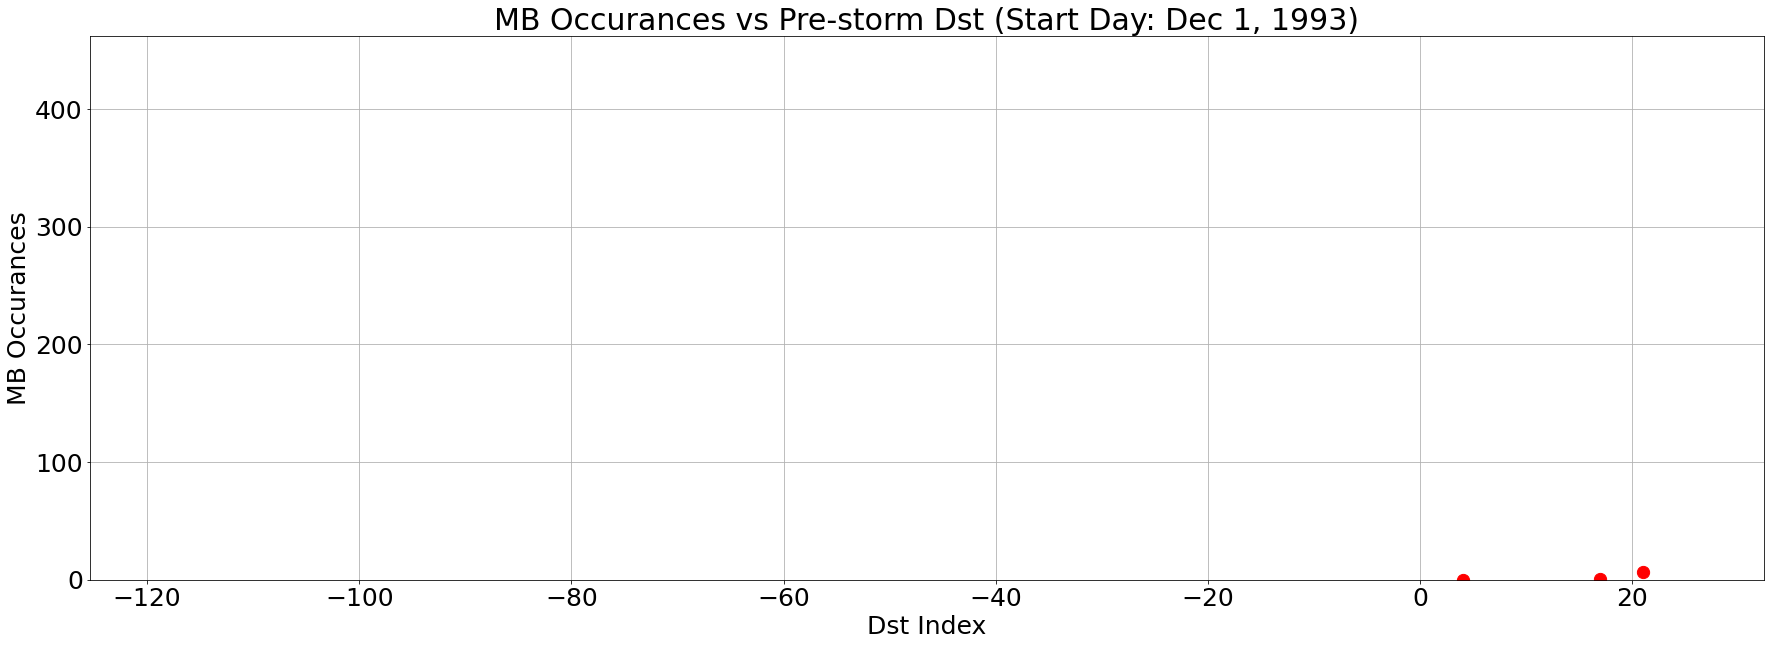

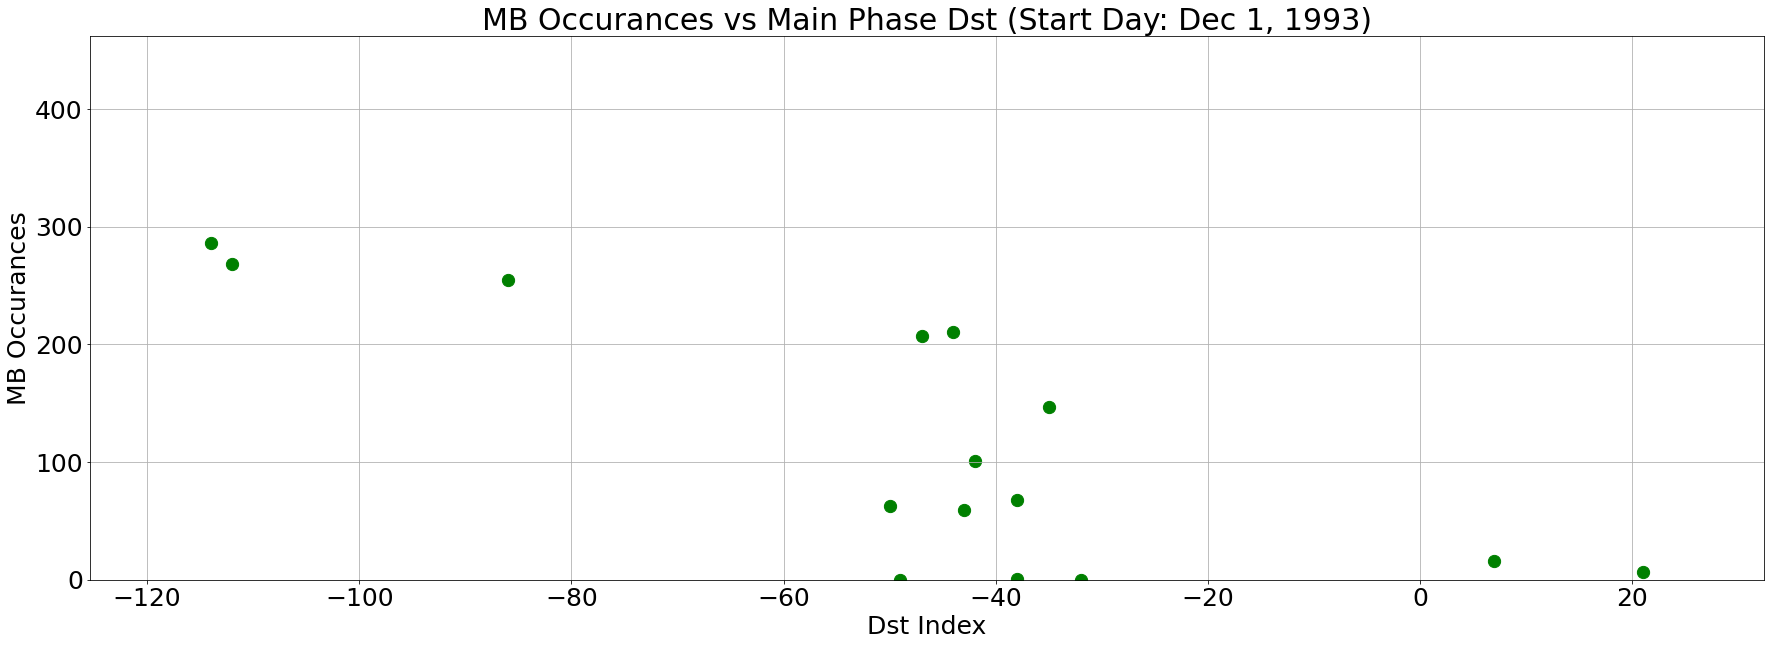

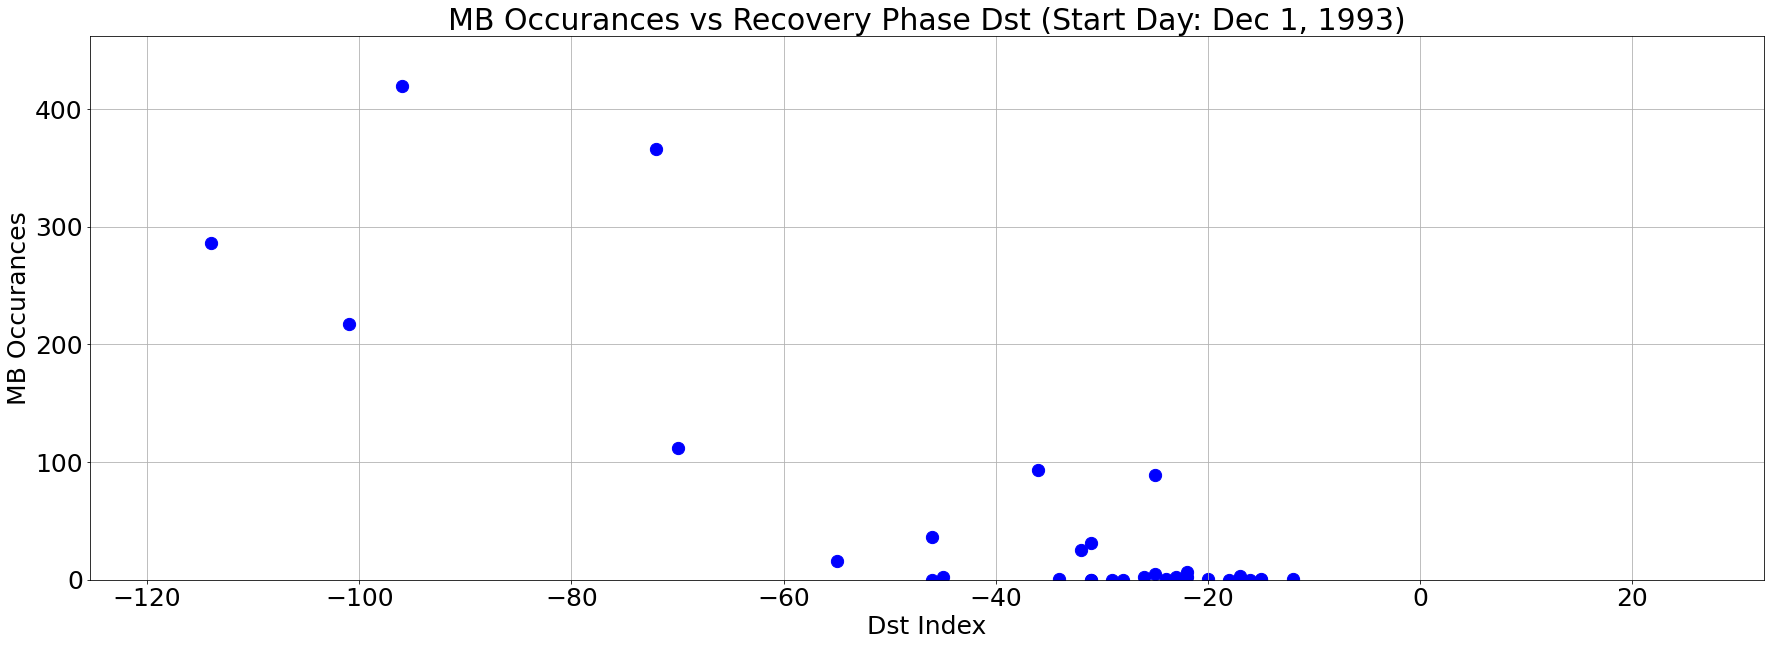

In [262]:
plt.figure(figsize = (30,10))
plt.title(f'MB Occurances vs AE (Start Day: {month_list[month-1]} {day}, {year})', fontsize = 30)
plt.scatter(AE_per3hrs, H[0], s=150, c='royalblue')
plt.ylim(0, np.max(H[0])+np.max(H[0])/10)
plt.xlim(0, np.max(AE_per3hrs)+np.max(AE_per3hrs)/10)
plt.xlabel('AE Index', fontsize = 25)
plt.ylabel('MB Occurances', fontsize = 25)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.grid(True)
plt.savefig(pic_directory + 'MB-Occ_vs_AE_' + year + start_day + '-' + year + end_day + '.png')
plt.show()

plt.figure(figsize = (30,10))
plt.title(f'MB Occurances vs Pre-storm Dst (Start Day: {month_list[month-1]} {day}, {year})', fontsize = 30)
plt.scatter(Dst_prestorm, H[0][t_per3hrs <= t_Dmax[0]], s=150, c='red')
plt.ylim(0, np.max(H[0])+np.max(H[0])/10)
plt.xlim(np.min(Dst_per3hrs)-np.abs(np.min(Dst_per3hrs)/10), np.max(Dst_per3hrs)+np.abs(np.min(Dst_per3hrs)/10))
plt.xlabel('Dst Index', fontsize = 25)
plt.ylabel('MB Occurances', fontsize = 25)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.grid(True)
plt.savefig(pic_directory + 'MB-Occ_vs_Pre-Dst_' + year + start_day + '-' + year + end_day + '.png')
plt.show()

plt.figure(figsize = (30,10))
plt.title(f'MB Occurances vs Main Phase Dst (Start Day: {month_list[month-1]} {day}, {year})', fontsize = 30)
plt.scatter(Dst_mainphase, H[0][(t_per3hrs >= t_Dmax[0]) & (t_per3hrs <= t_Dmin[0])], s=150, c='green')
plt.ylim(0, np.max(H[0])+np.max(H[0])/10)
plt.xlim(np.min(Dst_per3hrs)-np.abs(np.min(Dst_per3hrs)/10), np.max(Dst_per3hrs)+np.abs(np.min(Dst_per3hrs)/10))
plt.xlabel('Dst Index', fontsize = 25)
plt.ylabel('MB Occurances', fontsize = 25)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.grid(True)
plt.savefig(pic_directory + 'MB-Occ_vs_Main-Dst_' + year + start_day + '-' + year + end_day + '.png')
plt.show()

plt.figure(figsize = (30,10))
plt.title(f'MB Occurances vs Recovery Phase Dst (Start Day: {month_list[month-1]} {day}, {year})', fontsize = 30)
plt.scatter(Dst_recovery, H[0][t_per3hrs >= t_Dmin[0]], s=150, c='blue')
plt.ylim(0, np.max(H[0])+np.max(H[0])/10)
plt.xlim(np.min(Dst_per3hrs)-np.abs(np.min(Dst_per3hrs)/10), np.max(Dst_per3hrs)+np.abs(np.min(Dst_per3hrs)/10))
plt.xlabel('Dst Index', fontsize = 25)
plt.ylabel('MB Occurances', fontsize = 25)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.grid(True)
plt.savefig(pic_directory + 'MB-Occ_vs_Rec-Dst_' + year + start_day + '-' + year + end_day + '.png')
plt.show()